In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
import matplotlib.pyplot as plt
# from iblutil.util import setup_logger
# setup_logger('ibllib', level='DEBUG')
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas(res_um=10)

one = ONE(base_url='https://alyx.internationalbrainlab.org')
pid = "b0b6a756-8b8a-4cee-9f4f-da0daab9790d"

ssl = SpikeSortingLoader(one=one, pid=pid, atlas = ba)
channels = ssl.load_channels()
spikes, clusters, channels = ssl.load_spike_sorting()
print (spikes)


/home/openlab/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


{'depths': array([2704.03369141, 1004.91400146, 1497.98974609, ..., 1045.65966797,
       1837.00073242, 1799.4876709 ]), 'clusters': array([ 989,  356, 1448, ...,  374,  658,  657], dtype=uint32), 'amps': array([9.77885528e-05, 1.13662614e-04, 1.10702692e-04, ...,
       8.04463670e-05, 6.02976212e-05, 8.20995563e-05]), 'times': array([1.22927333e-02, 1.56927336e-02, 1.61260670e-02, ...,
       4.07339144e+03, 4.07339497e+03, 4.07339507e+03])}


In [2]:
def basic_ephys (pid):#, pname, session_path):

    # 1. Load in spikesorting data for pid
    ssl = SpikeSortingLoader(one=one, pid=pid, atlas=ba)
    spikes, clusters, channels = ssl.load_spike_sorting()
    print (spikes)
    clusters = ssl.merge_clusters(spikes, clusters, channels)
    # 2. Evaluate the number of good clusters
    # The spikesortingloader loads data for all clusters (both mua and good) detected by the spikesorter.
    # We can restrict to only the good clusters by finding the clusters with a label of 1
    good_cluster_idx = clusters['label'] == 1
    print (good_cluster_idx)
    clusters_good = {key:val[good_cluster_idx] for key, val in clusters.items()}

    all_clusters = clusters['label'].shape
    good_clusters = clusters_good['label'].shape
    print(f'Total no. of clusters: {all_clusters}')
    print(f'Number of good clusters: {good_clusters}')

    # 3. Find the location of clusters in brain
    # The location of the clusters can be found in the atlas_id (Allen CCF ids) or acronym attributes of the clusters object
    acronyms = clusters_good['acronym']
    unique_acronyms, count = np.unique(acronyms, return_counts=True)
    for a, c in zip(unique_acronyms, count):
        print(f'{a}: {c}')

    # 4. Compute the firing rate of each cluster
    # The firing rate of each cluster can be found in the firing rate atrribute of the clusters object
    firing_rate = clusters_good['firing_rate']

    # To show the interaction between the clusters and the spikes object we will show how you can compute
    # the firing rate from the data

    # To compute the firing rate we first need to compute the number of spikes detected for each cluster
    n_spikes = np.empty((clusters_good['cluster_id'].shape))
    # Loop over the cluster ids
    for i, c in enumerate(clusters_good['cluster_id']):
        # Find location where each cluster id is found in the spikes objects and get the sum
        cidx = np.sum(spikes['clusters'] == c)
        n_spikes[i] = cidx

    # To compute the firing rate we can divide the spike count by the total duration of the recording
    duration = np.max(spikes['times']) - np.min(spikes['times'])
    firing_rate_from_spikes = n_spikes / duration
    # Make sure that the values for firing rates are the same
    np.array_equal(firing_rate_from_spikes, firing_rate)

    # 5. Plot firing rate and brain locations
    clusters_good.keys()
    norm = colors.Normalize(vmin=np.min(firing_rate), vmax=np.max(firing_rate), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
    firing_rate_cols = mapper.to_rgba(firing_rate)
    fig, axs = plt.subplots(1, 2)
    # Plot the brain regions through which the channels on the insertion pass
    plot_brain_regions(channels['atlas_id'], channel_depths=channels['axial_um'], ax=axs[0])
    # Plot scatter plot of cluster depths vs cluster amp with firing rate encoded in colour
    # Map firing rate values to colours
    norm = colors.Normalize(vmin=np.min(firing_rate), vmax=np.max(firing_rate), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
    firing_rate_cols = mapper.to_rgba(firing_rate)
    axs[1].scatter(clusters_good['amp_median'] * 1e6, clusters_good['depths'], c=firing_rate_cols)
    axs[1].set_xlabel('Amps (uV)')
    axs[1].get_yaxis().set_visible(False)
    cbar = fig.colorbar(mapper, ax=axs[1])
    cbar.set_label('Firing rate (Hz)')
    plt.show()
    plt.close(fig)
    return {a: c for a, c in zip(unique_acronyms, count)}


In [ ]:
dataset = 'spikes.times.npy'
brain_acronym = 'MO'
psychedelic_insertions = one.search_insertions(project=['psychedelics'])
psychedelic_insertions_spikes = one.search_insertions(project=['psychedelics'], datasets=dataset)
psychedelic_insertions_spikes_area = one.search_insertions(project=['psychedelics'], datasets=dataset, atlas_acronym=brain_acronym)

print(f'{len(psychedelic_insertions)-1} insertions in psychedelic project, of which \n{len(psychedelic_insertions_spikes)-1} have a spikes.times.npy file, \n{len(psychedelic_insertions_spikes_area)-1} with areas containing {brain_acronym} in their acronym')
datasets_loaded = {}
neurons_per_area = {}
errored_sessions = []
for pid in psychedelic_insertions_spikes:
    try:
        neurons_per_area[pid] = basic_ephys (pid)    
    except Exception as e:
        errored_sessions.append(pid)
        continue
    # ssl = SpikeSortingLoader(one=one, pid=pid)
    # channels = ssl.load_channels()
    # spikes, clusters, channels = ssl.load_spike_sorting()
    # print (spikes)


In [3]:
import pandas as pd 

# Assuming neurons_per_area is your dictionary

# Create a new dictionary where areas will be the keys
areas_dict = {}

for session, areas in neurons_per_area.items():
    for area, neuron_count in areas.items():
        if area not in areas_dict:
            # Create a new dictionary for each new area, with session ids as keys
            areas_dict[area] = {}
        areas_dict[area][session] = neuron_count

# Convert the dictionary to a DataFrame
df = pd.DataFrame(areas_dict).T.fillna(0)
df = df.sort_index()
# df = df[df.apply(lambda row: np.count_nonzero(row) >= 3, axis=1)]

print (df)

# Create the heatmap
fig, axs = plt.subplots(1, 2, figsize=(20,20))  # Adjust the size as needed.
heatmap = axs[0].imshow(df, cmap='hot', interpolation='nearest')

# Add labels to the axes
axs[0].set_xticks(range(df.shape[1]))
axs[0].set_xticklabels(df.columns, fontsize=10, rotation=90)
axs[0].set_yticks(range(df.shape[0]))
axs[0].set_yticklabels(df.index, fontsize=10)

# Add a colorbar
cbar = fig.colorbar(heatmap, ax=axs[0], fraction=0.046, pad=0.04)
cbar.set_label('Number of neurons')

# Label axes
axs[0].set_xlabel('Session ID')
axs[0].set_ylabel('Area')

# Create the number map
numbermap = axs[1].imshow(df, cmap='Greys', interpolation='nearest')

# Add labels to the axes
axs[1].set_xticks(range(df.shape[1]))
axs[1].set_xticklabels(df.columns, fontsize=10, rotation=90)
axs[1].set_yticks(range(df.shape[0]))
axs[1].set_yticklabels(df.index, fontsize=10)

# Add the neuron counts as text
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        axs[1].text(j, i, int(df.iloc[i, j]), ha="center", va="center", color="black", fontsize = 6)

# Label axes
axs[1].set_xlabel('Session ID')
axs[1].set_ylabel('Area')

# Show the plot
plt.tight_layout()
plt.show()

NameError: name 'neurons_per_area' is not defined

In [16]:
neurons_per_area

{'b0b6a756-8b8a-4cee-9f4f-da0daab9790d': {'ACAd5': 28,
  'ACAv5': 46,
  'LSc': 1,
  'LSr': 17,
  'MOs5': 6,
  'MS': 19,
  'STR': 3,
  'ccb': 7},
 '351ee92a-b405-4f34-96a8-75c44da54283': {'ACAd6a': 8,
  'ACAv6a': 5,
  'ACAv6b': 1,
  'LSr': 3,
  'MOs6a': 6,
  'STR': 1,
  'void': 1},
 '385d74d9-3ff4-4503-a831-b3dcc02ab0af': {'ACAd2/3': 5,
  'ACAd5': 72,
  'ACAv1': 5,
  'ACB': 3,
  'LSr': 31,
  'LSv': 14,
  'MOs5': 15,
  'STR': 10,
  'ccg': 1},
 '5ccc2e14-eb97-4d1e-abee-afe79ea87a81': {'CP': 51,
  'MOs6a': 13,
  'ccb': 5,
  'cing': 3},
 '9bea4082-90b6-444b-8926-c6e382a9edc6': {'ACAd6a': 19,
  'ACAv6b': 1,
  'BST': 1,
  'LSv': 4,
  'MOs5': 18,
  'MOs6a': 15,
  'STR': 1,
  'ccb': 2,
  'cing': 3},
 '83099467-4fc1-4c7f-bc54-faa3cbc2b51e': {'ACAd6a': 14,
  'ACAv5': 1,
  'ACAv6a': 27,
  'DP': 20,
  'MOs2/3': 23,
  'MOs5': 27,
  'PL5': 20,
  'PL6a': 4,
  'void': 2},
 'b2e7b6f5-8f07-441b-951a-fb160c174dcc': {'ACAd5': 4,
  'ACAd6a': 6,
  'DP': 11,
  'ILA5': 31,
  'ILA6a': 1,
  'MOs5': 29,
  'PL6a':

52 insertions in psychedelic project, of which 
47 have a spikes.times.npy file, 
16 with areas containing MO in their acronym
{'amps': array([6.60744470e-05, 5.99503707e-05, 9.23586869e-05, ...,
       8.61179496e-05, 5.09265052e-05, 9.52624148e-05]), 'times': array([1.58609520e-02, 1.96276045e-02, 2.16275970e-02, ...,
       4.04291858e+03, 4.04291961e+03, 4.04292248e+03]), 'depths': array([ 376.22302246,  531.6149292 ,  171.60418701, ...,  364.3414917 ,
       2363.38476562,  565.07189941]), 'clusters': array([170, 263,  57, ..., 163, 975, 288], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1610,)
Number of good clusters: (61,)
CA1: 35
VISp4: 4
VISp5: 12
VISp6a: 7
VISp6b: 2
alv: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


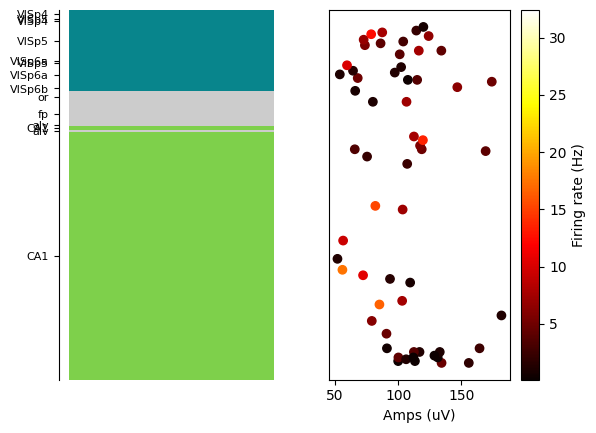

{'amps': array([4.25858789e-05, 2.99953828e-05, 6.00699266e-05, ...,
       3.46177964e-04, 1.01090523e-04, 2.74589867e-04]), 'depths': array([2791.34619141, 2752.40869141,  499.86154175, ..., 3815.84863281,
       3817.45947266, 3789.07104492]), 'times': array([2.00475264e-02, 2.24141936e-02, 2.43141940e-02, ...,
       4.08745994e+03, 4.08746120e+03, 4.08746900e+03]), 'clusters': array([ 972,  971,  284, ..., 1468, 1482, 1467], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1541,)
Number of good clusters: (24,)
ENTl5: 4
ENTl6a: 1
SSp-bfd6a: 14
SSp-bfd6b: 4
or: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


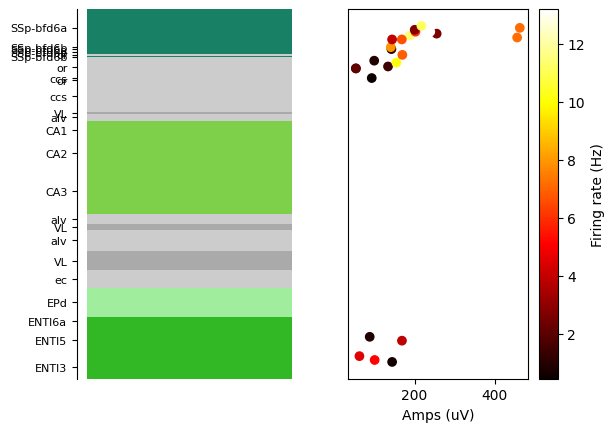

{'depths': array([2704.03369141, 1004.91400146, 1497.98974609, ..., 1045.65966797,
       1837.00073242, 1799.4876709 ]), 'clusters': array([ 989,  356, 1448, ...,  374,  658,  657], dtype=uint32), 'amps': array([9.77885528e-05, 1.13662614e-04, 1.10702692e-04, ...,
       8.04463670e-05, 6.02976212e-05, 8.20995563e-05]), 'times': array([1.22927333e-02, 1.56927336e-02, 1.61260670e-02, ...,
       4.07339144e+03, 4.07339497e+03, 4.07339507e+03])}
[False False False ... False False False]
Total no. of clusters: (1597,)
Number of good clusters: (127,)
ACAd5: 28
ACAv5: 46
LSc: 1
LSr: 17
MOs5: 6
MS: 19
STR: 3
ccb: 7


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


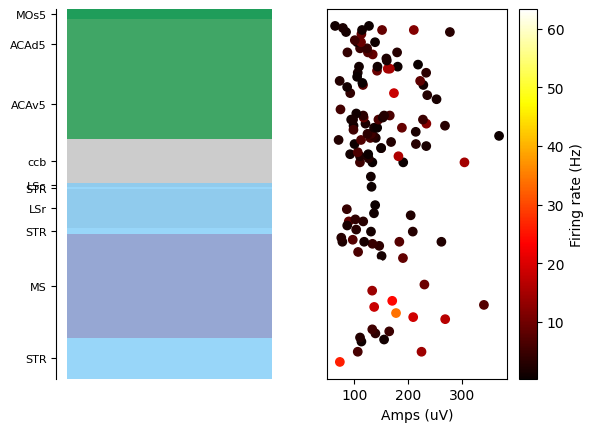

{'depths': array([ 795.23431396, 3011.79272461, 2539.54443359, ...,  790.52703857,
       3204.39746094, 1976.58032227]), 'amps': array([9.55636559e-05, 1.53063490e-04, 1.65734658e-04, ...,
       2.35458723e-04, 2.56876022e-04, 1.32604457e-04]), 'clusters': array([ 162, 1088,  850, ...,  149, 1185,  537], dtype=uint32), 'times': array([1.15081071e-02, 1.36080991e-02, 1.43747629e-02, ...,
       4.07339487e+03, 4.07339574e+03, 4.07339594e+03])}
[False False False ... False False False]
Total no. of clusters: (1670,)
Number of good clusters: (116,)
COApm: 1
LP: 15
MEA: 8
PA: 2
PO: 16
VPL: 19
VPM: 45
ZI: 4
fiber tracts: 3
int: 3


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


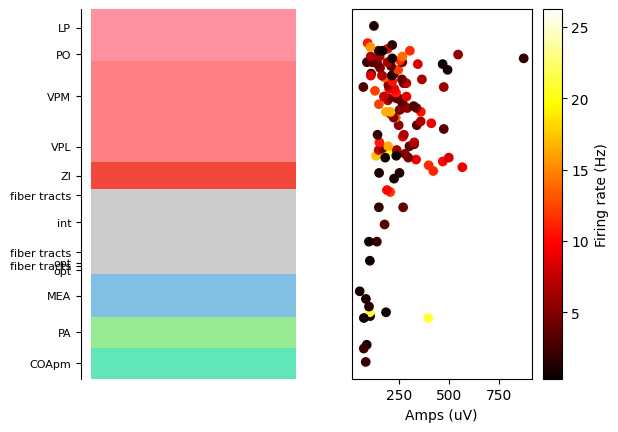

{'times': array([1.58464008e-02, 2.02464009e-02, 2.12797343e-02, ...,
       4.17360036e+03, 4.17360743e+03, 4.17361573e+03]), 'clusters': array([ 518,  891,  124, ..., 1097, 1513, 1032], dtype=uint32), 'amps': array([6.78223822e-05, 1.07214877e-04, 4.55466726e-05, ...,
       6.56665228e-05, 6.34656559e-05, 9.59760620e-05]), 'depths': array([1189.56201172, 1794.20996094,  167.8216095 , ..., 2142.64697266,
       2929.8984375 , 2044.85009766])}
[False False False ... False False False]
Total no. of clusters: (1528,)
Number of good clusters: (25,)
ACAd6a: 8
ACAv6a: 5
ACAv6b: 1
LSr: 3
MOs6a: 6
STR: 1
void: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


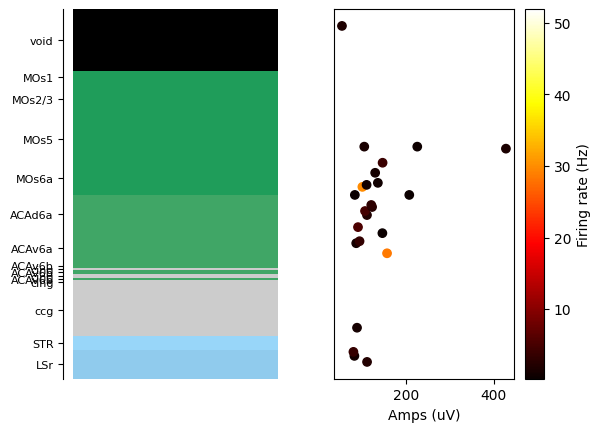

{'clusters': array([  82,  199,  981, ..., 1052,  488, 1425], dtype=uint32), 'depths': array([ 242.99723816,  492.03295898, 2208.9362793 , ..., 2324.88452148,
       1060.97827148,  819.69317627]), 'amps': array([6.07264373e-05, 9.85908655e-05, 1.71208091e-04, ...,
       1.60877406e-04, 7.14915302e-05, 3.58652196e-05]), 'times': array([1.35004644e-02, 1.63671199e-02, 1.67671183e-02, ...,
       4.17362858e+03, 4.17363042e+03, 4.17363322e+03])}
[False False False ... False False False]
Total no. of clusters: (1518,)
Number of good clusters: (63,)
BLAa: 16
CEAc: 19
CP: 4
GPe: 18
STR: 3
ec: 1
int: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


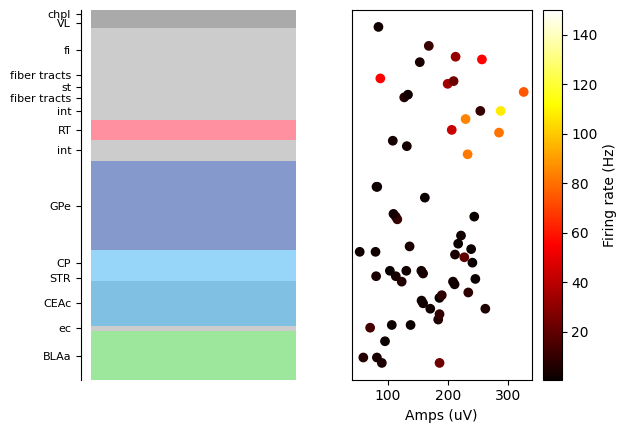

{'times': array([1.52656089e-02, 1.62989424e-02, 1.71656093e-02, ...,
       4.31802582e+03, 4.31802665e+03, 4.31802865e+03]), 'depths': array([2977.36694336, 2986.24389648, 2640.60668945, ...,  190.9571991 ,
       2781.90576172, 2464.50146484]), 'amps': array([1.75516593e-04, 1.29846273e-04, 2.82302639e-04, ...,
       6.67942640e-05, 1.41718621e-04, 1.56659769e-04]), 'clusters': array([1057, 1055,  858, ...,   27,  952,  716], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1621,)
Number of good clusters: (73,)
BMAa: 1
CTXsp: 1
LD: 1
MEA: 4
RT: 2
VPL: 21
VPM: 39
em: 1
int: 3


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


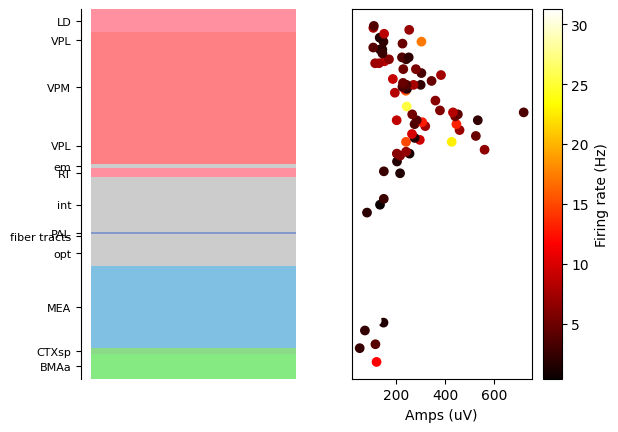

{'times': array([1.21004343e-02, 1.25004328e-02, 1.42337598e-02, ...,
       4.31801731e+03, 4.31801938e+03, 4.31802044e+03]), 'clusters': array([ 538,  496,  595, ..., 1089,  444, 1205], dtype=uint32), 'depths': array([1062.12683105,  958.32342529, 1164.41540527, ..., 3002.4375    ,
        848.37890625, 3262.15844727]), 'amps': array([7.25211036e-05, 5.90359746e-05, 3.43101633e-05, ...,
       5.50130994e-05, 6.21509503e-05, 8.07757097e-05])}
[False False False ... False False False]
Total no. of clusters: (1804,)
Number of good clusters: (156,)
ACAd2/3: 5
ACAd5: 72
ACAv1: 5
ACB: 3
LSr: 31
LSv: 14
MOs5: 15
STR: 10
ccg: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


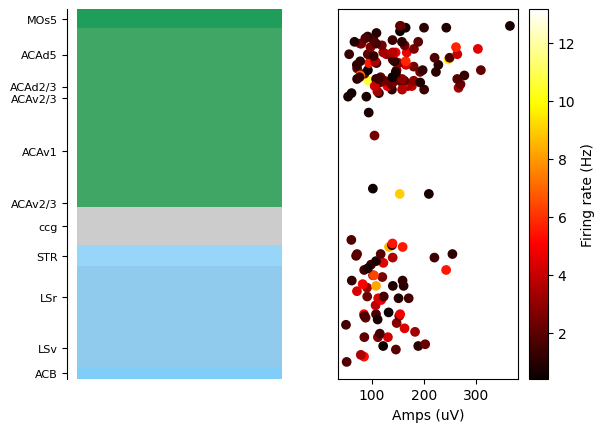

{'depths': array([ 136.92784119, 2124.02441406, 3039.92724609, ...,  134.04785156,
       1902.38769531, 2862.19775391]), 'amps': array([6.49659423e-05, 8.45836968e-05, 2.22119939e-04, ...,
       7.35419792e-05, 1.24327865e-04, 6.32630317e-05]), 'clusters': array([ 25, 564, 907, ...,  25, 508, 798], dtype=uint32), 'times': array([1.07880343e-02, 1.49546851e-02, 1.75880084e-02, ...,
       4.09711977e+03, 4.09712140e+03, 4.09712430e+03])}
[False False False ... False False False]
Total no. of clusters: (1455,)
Number of good clusters: (72,)
CP: 51
MOs6a: 13
ccb: 5
cing: 3


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


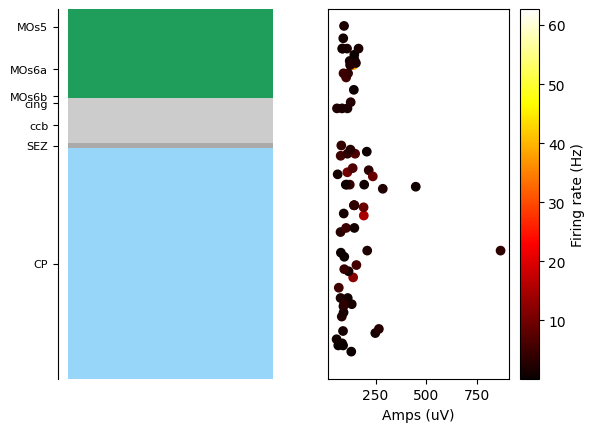

{'clusters': array([ 391,  283, 1433, ...,  342,  210,  520], dtype=uint32), 'depths': array([1378.36096191, 1107.73413086, 2333.77026367, ..., 1283.8347168 ,
        874.85357666, 1736.87158203]), 'times': array([8.61084164e-03, 1.36441760e-02, 1.45441761e-02, ...,
       4.09712097e+03, 4.09712183e+03, 4.09712343e+03]), 'amps': array([2.20722795e-04, 1.53335034e-04, 1.35868609e-04, ...,
       1.47056846e-04, 6.72908902e-05, 1.12057348e-04])}
[False False False ... False False False]
Total no. of clusters: (1662,)
Number of good clusters: (153,)
CA1: 1
CM: 6
DG-mo: 2
DG-po: 17
DG-sg: 12
LH: 12
MD: 70
RE: 4
RH: 12
TH: 10
Xi: 4
fr: 1
sm: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


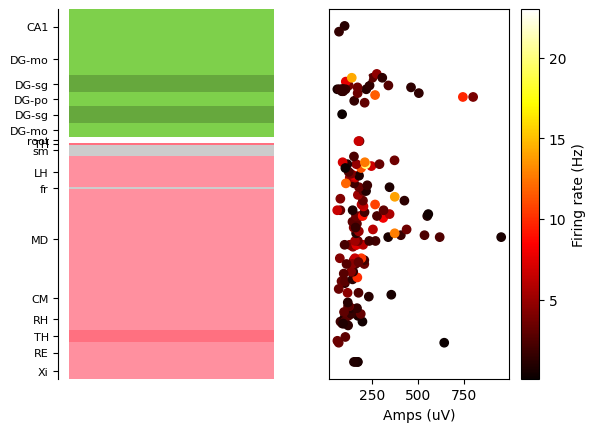

{'clusters': array([ 588,  590, 1133, ...,  255, 1522,  650], dtype=uint32), 'depths': array([1441.11303711, 1459.59643555, 2768.83764648, ...,  558.60528564,
       1130.00073242, 1587.97583008]), 'amps': array([8.95385884e-05, 1.81415521e-04, 3.93925915e-05, ...,
       6.58516190e-05, 6.47588427e-05, 7.59074488e-05]), 'times': array([1.09322516e-02, 1.11322516e-02, 1.25989186e-02, ...,
       4.15928748e+03, 4.15929205e+03, 4.15929395e+03])}
[False False False ... False False False]
Total no. of clusters: (1643,)
Number of good clusters: (118,)
CA1: 8
CM: 31
DG-mo: 1
DG-sg: 3
IMD: 15
LH: 1
MD: 49
PVT: 4
RH: 1
TH: 3
VPMpc: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


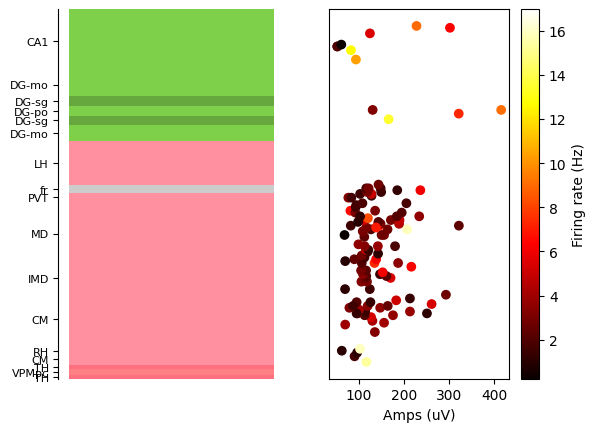

{'clusters': array([ 912,  408, 1211, ...,  949,  912, 1481], dtype=uint32), 'times': array([8.54761906e-03, 1.28142703e-02, 1.37476003e-02, ...,
       4.15928872e+03, 4.15928975e+03, 4.15929709e+03]), 'depths': array([2784.39111328, 1381.05541992, 3318.16308594, ..., 2858.78466797,
       2768.23608398,  253.00004578]), 'amps': array([5.91822711e-05, 3.66432140e-05, 5.71917899e-05, ...,
       8.21843483e-05, 4.97237519e-05, 5.78911903e-05])}
[False False False ... False False False]
Total no. of clusters: (1589,)
Number of good clusters: (64,)
ACAd6a: 19
ACAv6b: 1
BST: 1
LSv: 4
MOs5: 18
MOs6a: 15
STR: 1
ccb: 2
cing: 3


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


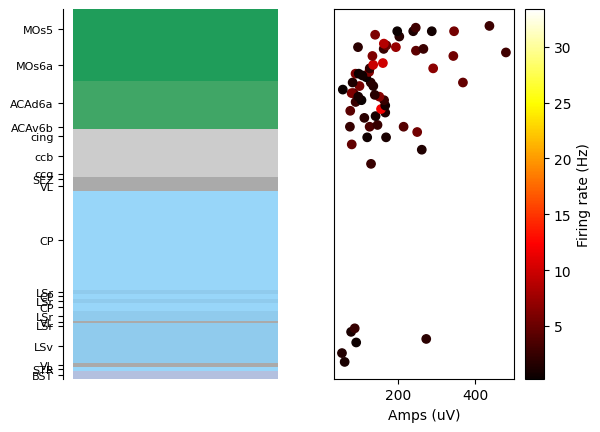

{'amps': array([1.04253494e-04, 7.59217938e-05, 1.19212457e-04, ...,
       6.91262033e-05, 1.06852134e-04, 1.23211854e-04]), 'times': array([1.38092548e-02, 1.60092382e-02, 1.97425434e-02, ...,
       3.94289070e+03, 3.94289113e+03, 3.94289213e+03]), 'depths': array([ 984.55993652, 1945.80529785, 2003.94677734, ...,  696.29650879,
        804.15905762,  776.93664551]), 'clusters': array([ 335,  848,  884, ...,  188,  233, 1634], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1679,)
Number of good clusters: (132,)
AUDd5: 38
AUDp5: 42
AUDv4: 4
AUDv5: 25
SSs5: 21
TEa4: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


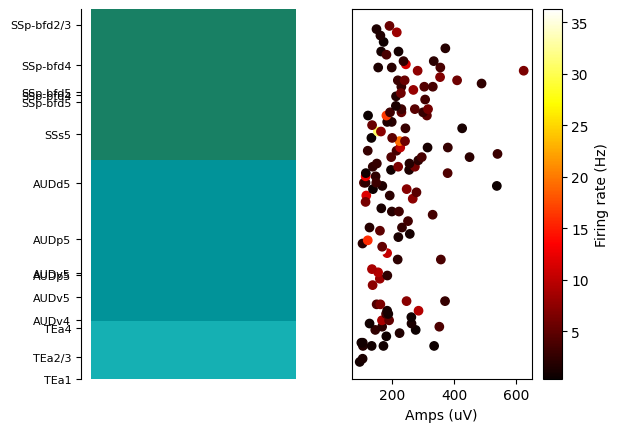

2024-11-07 14:57:29 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
{'depths': array([ 807.28613281,   99.59980774, 3406.73876953, ...,   81.78833008,
       1891.90063477,  433.33959961]), 'amps': array([7.80348412e-05, 1.13675515e-04, 4.37344360e-05, ...,
       9.37971654e-05, 5.30916706e-05, 5.17267250e-05]), 'times': array([1.41603998e-02, 1.66604005e-02, 1.81604009e-02, ...,
       4.16564175e+03, 4.16564565e+03, 4.16564981e+03]), 'clusters': array([ 308,   58, 1188, ...,   37,  687, 1364], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1724,)
Number of good clusters: (143,)
{'clusters': array([ 397,  533,  506, ...,  812,  381, 1397], dtype=uint32), 'depths': array([ 897.79760742, 1071.39355469,  968.47888184, ..., 1518.36572266,
        881.20440674, 3749.15527344]), 'times': array([1.58487950e-02, 1.80821105e-02, 1.81487766e-02, ...,
       3.94754319e+03, 3.94754389e+03, 3.94754432e+03]), 'amps': arr

/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


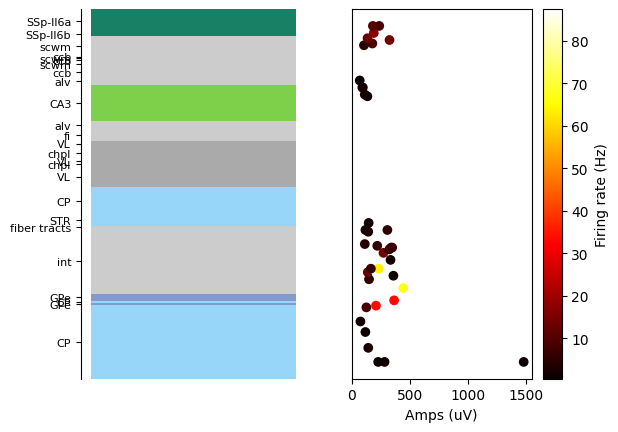

{'times': array([1.29988692e-02, 1.88655354e-02, 2.12988685e-02, ...,
       3.94754125e+03, 3.94754375e+03, 3.94754402e+03]), 'clusters': array([  88,  351,   55, ..., 1182, 1111, 1265], dtype=uint32), 'amps': array([1.90974063e-04, 7.64595648e-05, 8.66910074e-05, ...,
       1.64669747e-04, 1.68524764e-04, 1.02136631e-04]), 'depths': array([ 201.37730408,  668.89123535,  126.47268677, ..., 2434.92480469,
       2357.27368164, 2581.73828125])}
[False False False ... False False False]
Total no. of clusters: (1657,)
Number of good clusters: (138,)
ACAd6a: 14
ACAv5: 1
ACAv6a: 27
DP: 20
MOs2/3: 23
MOs5: 27
PL5: 20
PL6a: 4
void: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


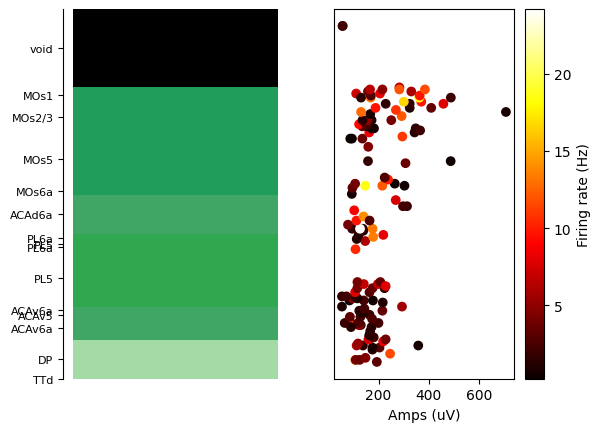

{'clusters': array([ 486,  705,  199, ..., 1069,  466, 1480], dtype=uint32), 'amps': array([2.20773403e-04, 7.91166673e-05, 7.79017687e-05, ...,
       1.27516732e-04, 7.37926956e-05, 4.62043221e-05]), 'times': array([1.73921462e-02, 1.77921461e-02, 2.91588105e-02, ...,
       3.94448159e+03, 3.94448222e+03, 3.94448225e+03]), 'depths': array([1138.28088379, 1633.20410156,  528.52050781, ..., 2468.11621094,
       1090.08728027,  747.69909668])}
[False False False ... False False False]
Total no. of clusters: (1659,)
Number of good clusters: (115,)
ACAd5: 4
ACAd6a: 6
DP: 11
ILA5: 31
ILA6a: 1
MOs5: 29
PL6a: 27
TTd: 6


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


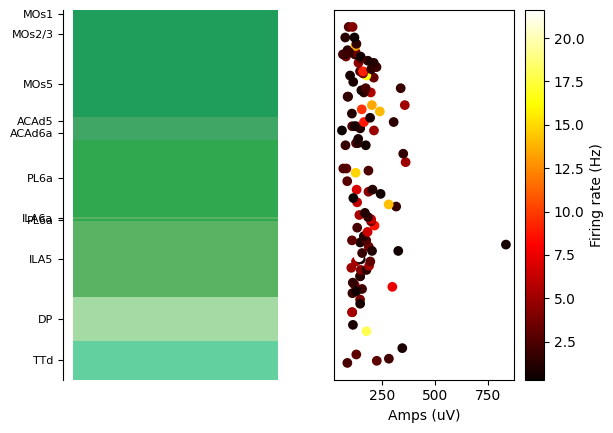

2024-11-07 14:57:45 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
{'times': array([2.93857879e-02, 3.04857790e-02, 3.05524451e-02, ...,
       3.94447271e+03, 3.94447471e+03, 3.94447854e+03]), 'depths': array([2009.51733398, 1876.5513916 ,  204.93972778, ..., 1618.49438477,
       3288.01586914, 1944.87670898]), 'clusters': array([ 787,  766,   22, ...,  622, 1243,  772], dtype=uint32), 'amps': array([2.74714165e-05, 2.31153031e-05, 3.94887794e-05, ...,
       2.42606926e-05, 3.31517719e-05, 4.16417440e-05])}
[False False False ... False False False]
Total no. of clusters: (1475,)
Number of good clusters: (0,)
{'clusters': array([ 155, 1559,  929, ...,  571,  107, 1519], dtype=uint32), 'times': array([2.01567916e-02, 2.07567866e-02, 2.44567560e-02, ...,
       4.00993949e+03, 4.00994199e+03, 4.00994292e+03]), 'amps': array([1.78731976e-04, 5.68975411e-05, 1.09076745e-04, ...,
       1.95167129e-04, 1.01686631e-04, 7.82768935e-05]), 'depths':

/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


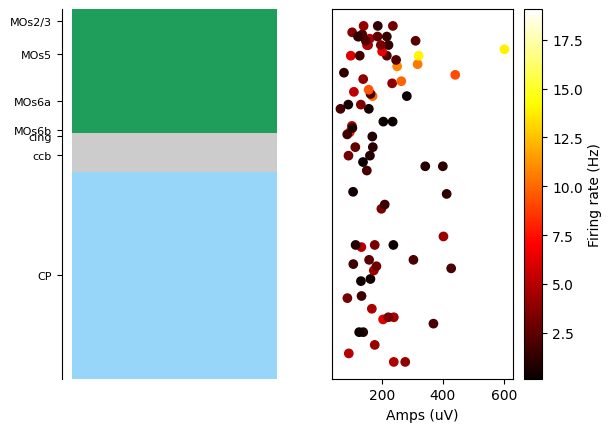

{'depths': array([ 578.08911133, 2171.47509766, 1075.8614502 , ..., 1893.29907227,
       1893.27026367,  828.5177002 ]), 'clusters': array([169, 841, 358, ..., 752, 755, 273], dtype=uint32), 'amps': array([8.61380854e-05, 1.10868581e-04, 9.94182048e-05, ...,
       1.43093060e-04, 1.53377144e-04, 1.04855728e-04]), 'times': array([1.44091037e-02, 1.52091035e-02, 1.90424358e-02, ...,
       4.00993532e+03, 4.00993556e+03, 4.00993709e+03])}
[False False False ... False False False]
Total no. of clusters: (1615,)
Number of good clusters: (95,)
CA1: 6
CM: 1
DG-mo: 2
DG-po: 7
DG-sg: 5
LH: 12
MD: 56
RH: 4
SMT: 1
sm: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


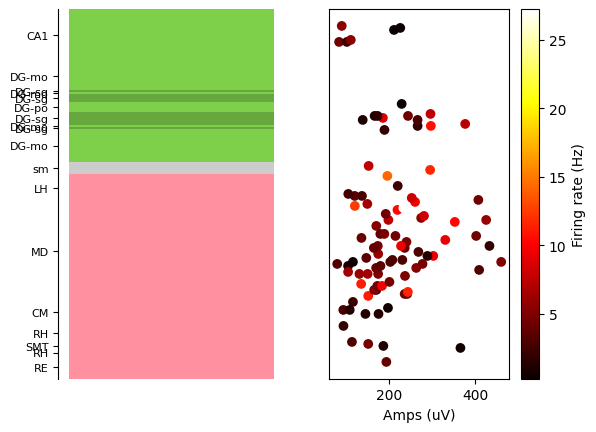

{'times': array([1.02687543e-02, 1.88020864e-02, 2.18354192e-02, ...,
       3.99430213e+03, 3.99430223e+03, 3.99430947e+03]), 'clusters': array([1246, 1017, 1261, ..., 1017,  888,  816], dtype=uint32), 'depths': array([3360.22973633, 2696.14379883, 3344.40136719, ..., 2696.54345703,
       2423.93920898, 2225.92626953]), 'amps': array([7.41330228e-05, 8.53227316e-05, 1.97992331e-04, ...,
       1.02919697e-04, 8.64631964e-05, 1.00040359e-04])}
[False False False ... False False False]
Total no. of clusters: (1556,)
Number of good clusters: (60,)
DG-mo: 1
DG-po: 9
DG-sg: 2
LH: 3
MD: 44
RH: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


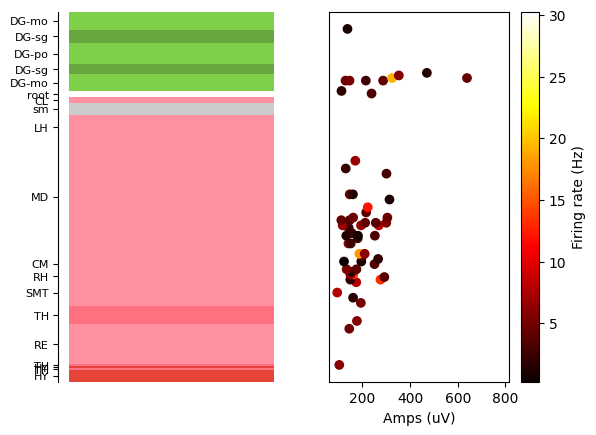

{'times': array([1.46433613e-02, 1.55766871e-02, 1.69766757e-02, ...,
       3.99430581e+03, 3.99430621e+03, 3.99430911e+03]), 'depths': array([1325.92578125, 2834.21337891, 1067.58898926, ...,  804.49035645,
       2878.04492188, 2303.58007812]), 'clusters': array([ 553, 1288,  418, ...,  284, 1290, 1021], dtype=uint32), 'amps': array([0.00010294, 0.00011277, 0.00014776, ..., 0.00015118, 0.00013557,
       0.00010371])}
[False False False ... False False False]
Total no. of clusters: (1620,)
Number of good clusters: (49,)
CP: 40
MOs6a: 6
MOs6b: 1
ccg: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


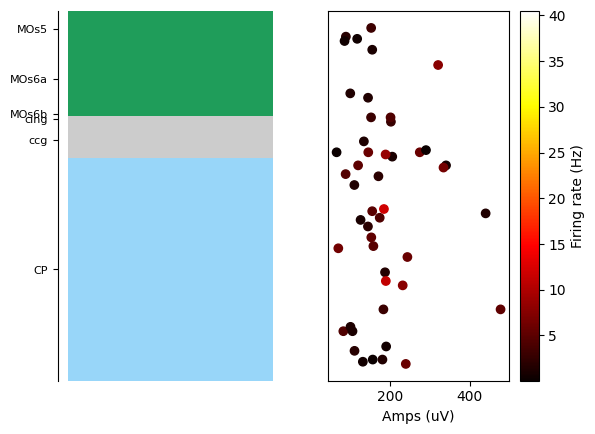

{'depths': array([2904.48510742, 2897.81689453, 2784.98681641, ...,  779.875     ,
        306.99621582, 2772.81860352]), 'clusters': array([1000,  995,  956, ...,  200,   51,  943], dtype=uint32), 'times': array([1.42696245e-02, 1.49362913e-02, 1.59362913e-02, ...,
       3.99402451e+03, 3.99402451e+03, 3.99403474e+03]), 'amps': array([1.85521191e-04, 7.23192152e-05, 8.88363661e-05, ...,
       5.33743755e-05, 3.47676013e-05, 2.26126282e-04])}
[False False False ... False False False]
Total no. of clusters: (1533,)
Number of good clusters: (65,)
CA1: 6
CA3: 1
CM: 4
DG-mo: 2
DG-po: 6
DG-sg: 5
LH: 3
MD: 29
RE: 4
RH: 1
SMT: 1
sm: 3


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


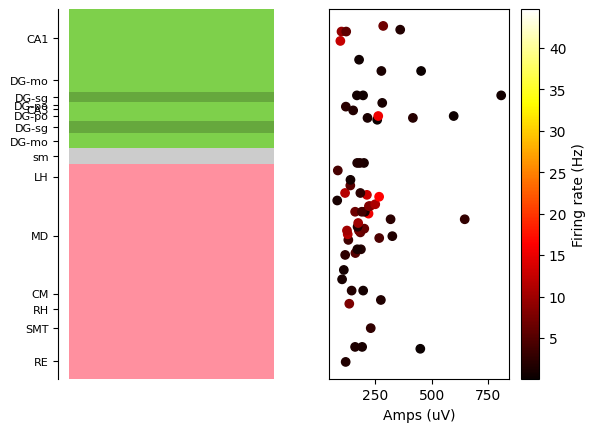

{'amps': array([9.54679107e-05, 8.98583798e-05, 8.53610324e-05, ...,
       3.31454219e-04, 1.01136688e-04, 1.38678556e-04]), 'clusters': array([1503, 1245,  886, ...,    2,  198,    6], dtype=uint32), 'times': array([1.34940487e-02, 1.37607133e-02, 1.83606770e-02, ...,
       3.99402487e+03, 3.99402524e+03, 3.99403027e+03]), 'depths': array([2189.86328125, 3030.81518555, 1998.65478516, ...,  110.47087097,
        493.41345215,   40.0265007 ])}
[False False False ... False False False]
Total no. of clusters: (1652,)
Number of good clusters: (71,)
CP: 21
MOs1: 3
MOs2/3: 11
MOs5: 16
MOs6a: 14
fa: 6


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


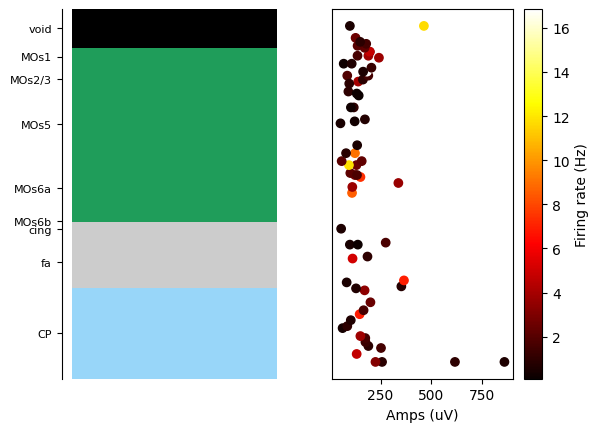

{'times': array([2.09134804e-02, 2.11134804e-02, 2.12468138e-02, ...,
       4.03942973e+03, 4.03943100e+03, 4.03943186e+03]), 'clusters': array([ 963,  252,  686, ...,  818,  689, 1567], dtype=uint32), 'depths': array([2295.49707031,  577.8458252 , 1680.05664062, ..., 1968.41259766,
       1706.63256836, 2144.82080078]), 'amps': array([6.92014951e-05, 8.54218781e-05, 7.87287536e-05, ...,
       3.37099299e-04, 9.14665775e-05, 1.05005366e-04])}
[False False False ... False  True False]
Total no. of clusters: (1600,)
Number of good clusters: (32,)
AUDv6a: 1
AUDv6b: 1
ECT5: 1
TEa5: 1
TEa6a: 3
VISrl5: 4
VISrl6a: 5
fp: 7
or: 9


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


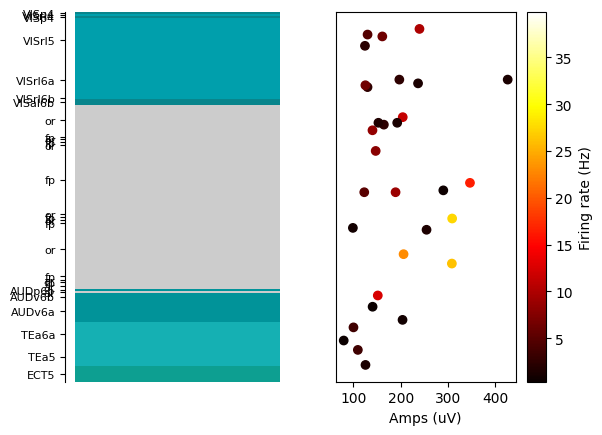

{'clusters': array([ 421,  421,  836, ..., 1098, 1398, 1257], dtype=uint32), 'depths': array([1020.08026123, 1011.29071045, 2374.63037109, ..., 2832.54711914,
       3487.43212891, 3131.66210938]), 'amps': array([8.72512412e-05, 1.18815604e-04, 7.28267314e-05, ...,
       1.03245805e-04, 8.57011574e-05, 6.71330438e-05]), 'times': array([1.02899142e-02, 1.48232107e-02, 1.74565227e-02, ...,
       3.94112320e+03, 3.94112937e+03, 3.94113374e+03])}
[False False False ... False False False]
Total no. of clusters: (1592,)
Number of good clusters: (58,)
ACAd6a: 1
LSr: 7
MOs2/3: 10
MOs5: 21
MOs6a: 14
MS: 1
SF: 2
cing: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


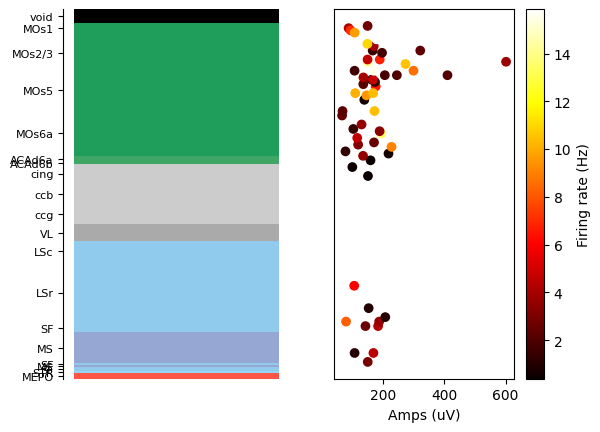

{'amps': array([0.00043016, 0.0001869 , 0.00015621, ..., 0.00014478, 0.00013997,
       0.00029541]), 'depths': array([1518.42749023,  859.21221924,  762.27740479, ..., 2134.86962891,
       1479.26977539, 1819.53686523]), 'clusters': array([686, 304, 243, ..., 998, 628, 883], dtype=uint32), 'times': array([1.06470557e-02, 1.48470553e-02, 1.53470552e-02, ...,
       3.94113470e+03, 3.94113690e+03, 3.94114300e+03])}
[False False False ... False False False]
Total no. of clusters: (1571,)
Number of good clusters: (31,)
CP: 15
GPe: 2
ccb: 2
chpl: 4
fiber tracts: 1
int: 4
or: 2
scwm: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


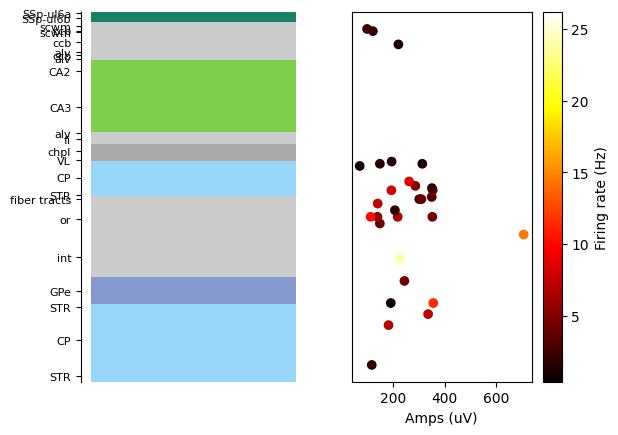

{'clusters': array([ 605, 1340, 1111, ...,  626,  605, 1333], dtype=uint32), 'times': array([7.44973530e-03, 1.76830693e-02, 2.03497361e-02, ...,
       4.00081587e+03, 4.00081624e+03, 4.00082041e+03]), 'depths': array([1932.87817383, 3586.51708984, 2996.72607422, ..., 1983.53601074,
       1952.83959961, 3536.28955078]), 'amps': array([9.73534328e-05, 1.54143496e-04, 1.04297835e-04, ...,
       9.25153476e-05, 1.09687922e-04, 5.92711023e-05])}
[False False False ... False False False]
Total no. of clusters: (1521,)
Number of good clusters: (25,)
CA3: 2
CL: 4
LP: 2
MD: 17


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


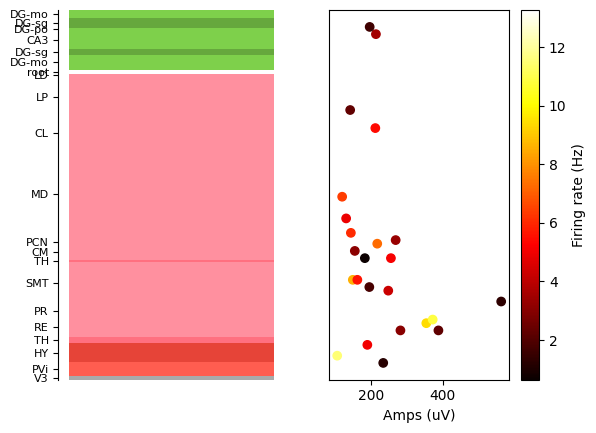

{'amps': array([6.26768703e-05, 5.08580580e-05, 1.96995865e-04, ...,
       1.99679875e-04, 6.18343197e-05, 1.11988991e-04]), 'depths': array([3547.16918945,  994.79284668, 3397.64477539, ..., 3829.78881836,
       3332.33813477, 3786.9934082 ]), 'times': array([1.32925459e-02, 1.36592096e-02, 1.88591685e-02, ...,
       4.00082039e+03, 4.00082113e+03, 4.00082343e+03]), 'clusters': array([1327,  234, 1262, ..., 1458, 1232, 1439], dtype=uint32)}
[False False  True ... False False False]
Total no. of clusters: (1656,)
Number of good clusters: (89,)
CP: 44
MOp6a: 43
scwm: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


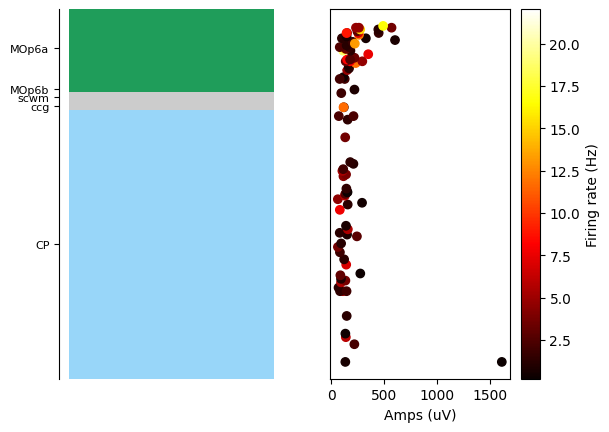

2024-11-07 14:58:31 WARNING  one.py:359  Histology tracing for probe01 does not exist. No channels for probe01
{'depths': array([1523.85571289, 2331.73095703, 1475.70239258, ..., 2282.28320312,
       3312.86035156, 3019.58837891]), 'clusters': array([ 521,  871,  515, ...,  869, 1248, 1217], dtype=uint32), 'times': array([1.85530882e-02, 1.99864693e-02, 2.11865093e-02, ...,
       3.96179098e+03, 3.96179725e+03, 3.96179731e+03]), 'amps': array([3.67513366e-05, 1.82271480e-05, 3.29226402e-05, ...,
       2.10838875e-05, 3.72010510e-05, 2.41972984e-05])}
[False False False ... False False False]
Total no. of clusters: (1510,)
Number of good clusters: (0,)
{'times': array([1.41945864e-02, 1.47612484e-02, 1.80612208e-02, ...,
       3.91766990e+03, 3.91767036e+03, 3.91767220e+03]), 'clusters': array([  67,  373,  660, ..., 1453,  294,  422], dtype=uint32), 'amps': array([1.06563969e-04, 1.50631488e-04, 1.13352475e-04, ...,
       8.13516352e-05, 6.05501790e-05, 1.23948708e-04]), 'depths':

/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


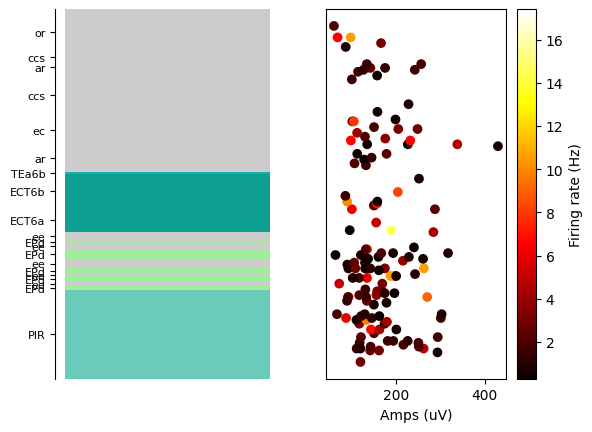

2024-11-07 14:58:39 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
{'depths': array([1945.74169922,  983.71392822, 2117.69775391, ...,  257.48126221,
       1080.01660156, 2819.64404297]), 'clusters': array([ 819,  345,  875, ...,   78,  404, 1145], dtype=uint32), 'times': array([2.06330516e-02, 3.07330495e-02, 3.16330493e-02, ...,
       3.91764261e+03, 3.91764671e+03, 3.91766515e+03]), 'amps': array([1.71662452e-05, 4.71063447e-05, 3.39975229e-05, ...,
       2.93641803e-05, 2.17363445e-05, 3.85605566e-05])}
[False False False ... False False False]
Total no. of clusters: (1499,)
Number of good clusters: (3,)
2024-11-07 14:58:42 WARNING  one.py:359  Histology tracing for probe00 does not exist. No channels for probe00
{'times': array([2.06806079e-02, 2.15139411e-02, 3.48472716e-02, ...,
       3.94587471e+03, 3.94587838e+03, 3.94587901e+03]), 'amps': array([1.49906736e-05, 1.66786242e-05, 3.00023925e-05, ...,
       1.95012396e-05, 1.720701

/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


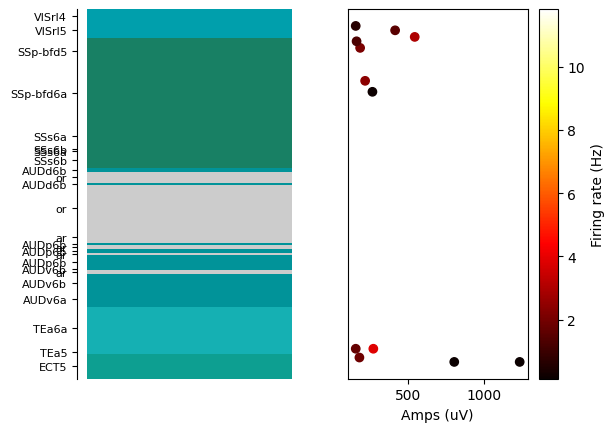

{'depths': array([1406.53540039,  510.47653198, 1078.31530762, ...,   28.08688354,
       2918.28271484, 1396.9909668 ]), 'clusters': array([ 624,  259, 1501, ...,   15, 1224,  618], dtype=uint32), 'amps': array([8.45896784e-05, 7.40618186e-05, 6.27354148e-05, ...,
       1.29900355e-04, 4.89706841e-05, 5.00023872e-05]), 'times': array([1.57794502e-02, 1.63127834e-02, 1.66461167e-02, ...,
       3.88785256e+03, 3.88785553e+03, 3.88785730e+03])}
[False False False ... False False False]
Total no. of clusters: (1605,)
Number of good clusters: (117,)
ACAv6a: 3
DP: 13
ILA5: 8
LSr: 39
MS: 8
NDB: 6
PL5: 13
PL6a: 12
STR: 3
TTd: 12


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


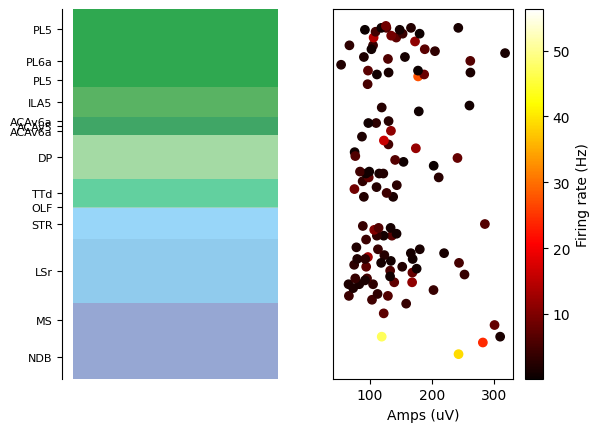

{'amps': array([0.00026417, 0.00012017, 0.00030416, ..., 0.00023682, 0.0001818 ,
       0.00018402]), 'depths': array([1762.95507812,  902.6630249 , 1558.05322266, ..., 2808.39404297,
       2597.13598633, 1965.98583984]), 'times': array([1.13051034e-02, 1.35384179e-02, 1.72383867e-02, ...,
       3.88785660e+03, 3.88785880e+03, 3.88785884e+03]), 'clusters': array([ 631,  325,  556, ..., 1220, 1090,  715], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1565,)
Number of good clusters: (46,)
BMAa: 13
CEAc: 6
CEAl: 5
CEAm: 1
EPv: 1
GPe: 6
PAA: 10
PAL: 2
STR: 1
void: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


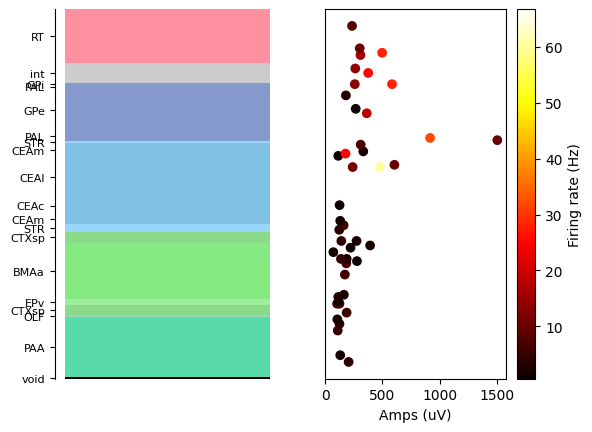

{'clusters': array([896, 842, 963, ..., 932, 101, 906], dtype=uint32), 'amps': array([8.20749951e-05, 7.85397525e-05, 5.24622574e-05, ...,
       2.95549750e-05, 2.15229670e-04, 3.23819716e-05]), 'depths': array([2376.02856445, 2239.17333984, 2443.82568359, ..., 2422.66943359,
        239.50131226, 2442.60595703]), 'times': array([1.42466941e-02, 1.43466933e-02, 1.46133577e-02, ...,
       3.89435797e+03, 3.89435810e+03, 3.89436327e+03])}
[False  True False ... False False False]
Total no. of clusters: (1541,)
Number of good clusters: (53,)
BLAa: 19
BLAp: 2
CEAc: 6
GPe: 3
RT: 17
STR: 1
ec: 1
fi: 2
int: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


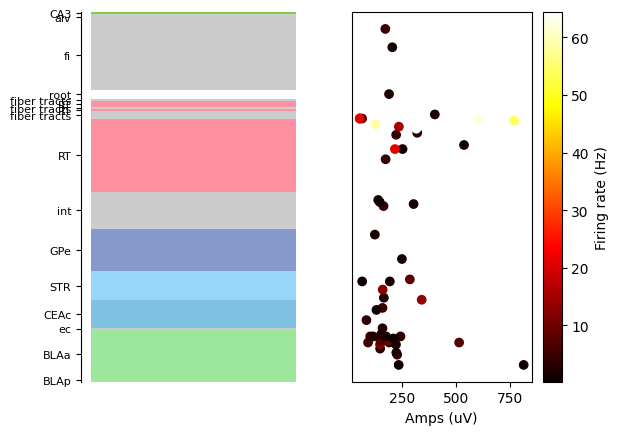

local file size mismatch on dataset: mainenlab/Subjects/ZFM-05725/2023-01-31/001/alf/probe00/pykilosort/clusters.metrics.pqt
(S3) /home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05725/2023-01-31/001/alf/probe00/pykilosort/clusters.metrics.pqt: 100%|██████████| 81.8k/81.8k [00:00<00:00, 129kB/s]


{'depths': array([3710.32495117, 1378.36279297, 2470.80883789, ..., 2470.80249023,
       3657.55517578, 2779.70849609]), 'times': array([1.61202709e-02, 1.96202698e-02, 2.05869362e-02, ...,
       3.89434291e+03, 3.89434751e+03, 3.89434828e+03]), 'clusters': array([1449,  589, 1046, ..., 1033, 1449, 1139], dtype=uint32), 'amps': array([1.94535624e-05, 2.33111426e-05, 1.62787715e-05, ...,
       2.06764056e-05, 1.49046116e-05, 2.21281212e-05])}
[False False False ... False False False]
Total no. of clusters: (1513,)
Number of good clusters: (0,)
{'amps': array([1.31651152e-04, 1.82334288e-04, 8.08361024e-05, ...,
       9.38064766e-05, 9.15262369e-05, 3.20175898e-04]), 'clusters': array([ 86,  90, 120, ..., 787, 576,  17], dtype=uint32), 'depths': array([ 254.11306763,  237.45298767,  333.76199341, ..., 2331.09472656,
       1728.07165527,   27.35435104]), 'times': array([1.18296888e-02, 1.60629863e-02, 2.56629051e-02, ...,
       3.97174062e+03, 3.97174422e+03, 3.97174672e+03])}
[Fals

/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


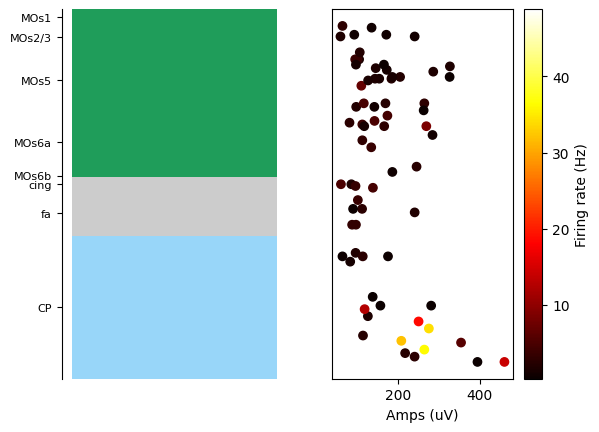

{'times': array([1.79645368e-02, 1.93311972e-02, 1.94645299e-02, ...,
       3.97173693e+03, 3.97173730e+03, 3.97174606e+03]), 'clusters': array([ 869,  290,  802, ...,  937, 1311,  854], dtype=uint32), 'amps': array([4.25078602e-05, 6.99190479e-05, 1.65925821e-04, ...,
       3.97050786e-05, 2.92947308e-05, 1.88000703e-05]), 'depths': array([2280.40429688,  886.86657715, 2101.07788086, ..., 2253.16845703,
       3657.78833008, 2241.29638672])}
[False False False ... False False False]
Total no. of clusters: (1541,)
Number of good clusters: (76,)
CA3: 5
HPF: 2
HY: 2
LD: 7
LP: 2
PO: 20
VAL: 23
VM: 11
ZI: 4


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


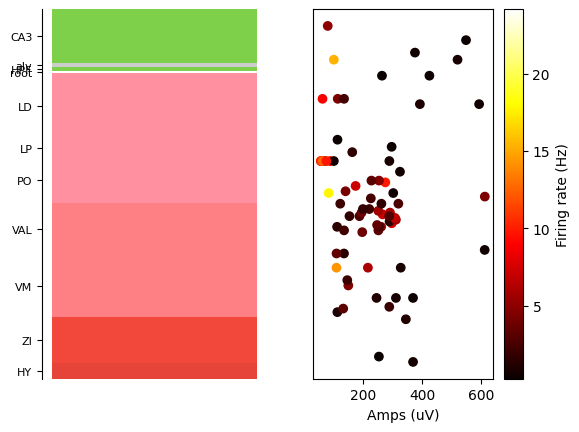

{'amps': array([5.30216938e-05, 8.43356548e-05, 7.59447925e-05, ...,
       1.29694268e-04, 2.95742708e-04, 9.82119350e-05]), 'depths': array([1131.54956055, 2875.85839844, 3390.81103516, ..., 3189.59204102,
        165.75335693,   31.19068909]), 'times': array([1.04701499e-02, 1.28701302e-02, 1.64034345e-02, ...,
       4.32154559e+03, 4.32154619e+03, 4.32155189e+03]), 'clusters': array([ 426, 1219, 1387, ..., 1331,    7,   14], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1749,)
Number of good clusters: (112,)
ACAd6a: 12
CP: 48
MOs2/3: 2
MOs5: 26
MOs6a: 13
PL6a: 1
PL6b: 2
cing: 4
fa: 4


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


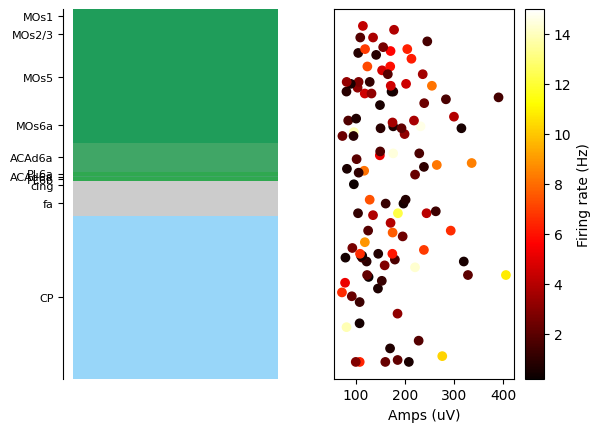

{'times': array([1.45189694e-02, 1.63522884e-02, 1.71856152e-02, ...,
       4.11870214e+03, 4.11870300e+03, 4.11870590e+03]), 'depths': array([1087.27172852,  903.4744873 , 1751.60632324, ..., 1316.24780273,
       2661.12963867,  500.4022522 ]), 'clusters': array([1476,  257, 1494, ...,  405, 1530,  157], dtype=uint32), 'amps': array([1.31813430e-04, 7.49115035e-05, 5.10716355e-05, ...,
       1.56114391e-04, 1.82976800e-04, 8.64220293e-05])}
[ True False False ... False False False]
Total no. of clusters: (1572,)
Number of good clusters: (64,)
CP: 16
EPd: 12
LA: 7
PIR: 11
SSp-bfd6a: 7
SSp-bfd6b: 1
STR: 1
VL: 1
amc: 4
ee: 1
or: 1
void: 2


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


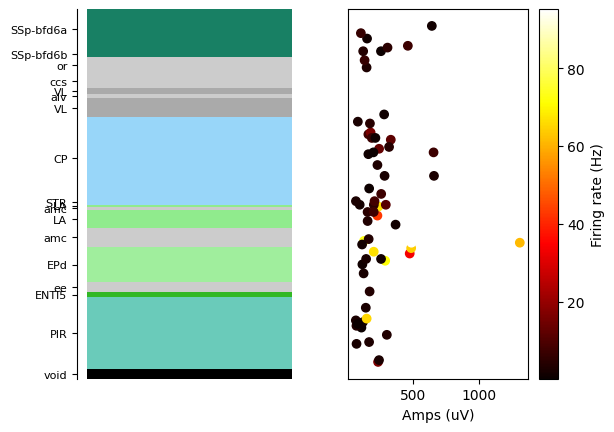

{'clusters': array([ 876, 1438, 1373, ..., 1425, 1421, 1380], dtype=uint32), 'amps': array([0.00011867, 0.000115  , 0.00015442, ..., 0.00013937, 0.00016981,
       0.00010799]), 'depths': array([2500.42260742, 3701.87109375, 3542.49047852, ..., 3624.24609375,
       3620.11645508, 3578.83251953]), 'times': array([1.67409950e-02, 1.95076505e-02, 2.33076353e-02, ...,
       4.11868849e+03, 4.11869055e+03, 4.11869172e+03])}
[False False False ... False False False]
Total no. of clusters: (1547,)
Number of good clusters: (20,)
ACAv5: 2
MOs2/3: 4
MOs5: 10
NDB: 1
OLF: 2
STR: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


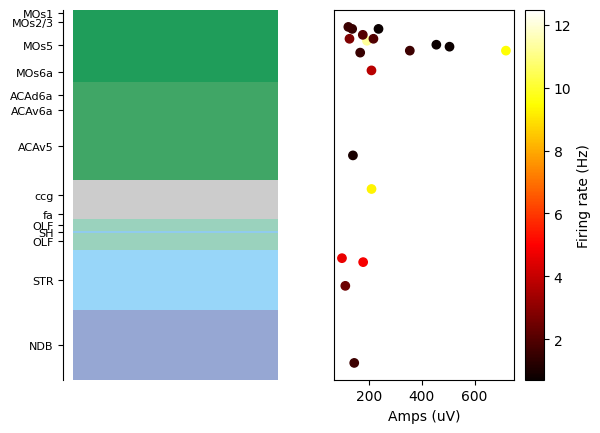

{'times': array([7.61818515e-03, 2.04514717e-02, 2.35181271e-02, ...,
       4.39470032e+03, 4.39470286e+03, 4.39470762e+03]), 'clusters': array([1348,  594,  695, ...,  216,  783, 1384], dtype=uint32), 'amps': array([1.01566384e-04, 9.47864666e-05, 5.81621413e-05, ...,
       9.60843702e-05, 1.31286426e-04, 6.82774949e-05]), 'depths': array([3493.26342773, 1274.88696289, 1543.5559082 , ...,  426.48693848,
       1735.68151855, 3589.11425781])}
[False False False ... False  True False]
Total no. of clusters: (1556,)
Number of good clusters: (43,)
ACAd6a: 1
ACAv1: 1
ACAv2/3: 9
ACAv5: 13
MOp1: 5
MOp2/3: 8
MOs2/3: 1
MOs5: 2
MOs6a: 1
TTd: 1
root: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


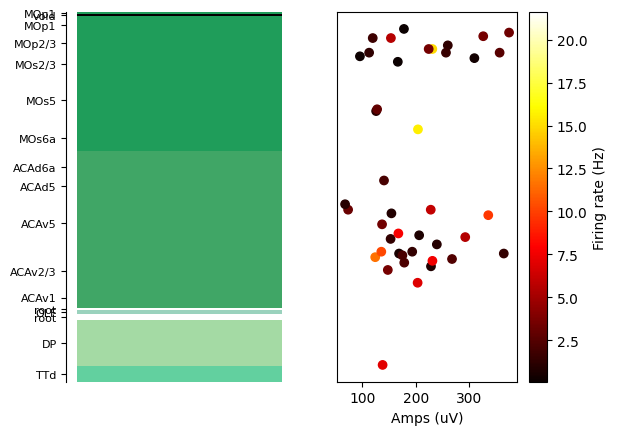

{'amps': array([1.56156131e-04, 1.13195679e-04, 2.02094259e-04, ...,
       1.47634324e-04, 7.87023733e-05, 6.62567596e-05]), 'depths': array([1981.85766602, 2235.95581055,  979.71166992, ..., 1921.453125  ,
       1791.82519531, 1740.43774414]), 'times': array([1.30305441e-02, 1.35972065e-02, 1.68638485e-02, ...,
       4.39470702e+03, 4.39470732e+03, 4.39470802e+03]), 'clusters': array([801, 939, 428, ..., 801, 758, 733], dtype=uint32)}
[False False False ... False False False]
Total no. of clusters: (1564,)
Number of good clusters: (72,)
BLAa: 14
CP: 18
EPv: 6
GPe: 8
PIR: 18
STR: 3
amc: 5


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


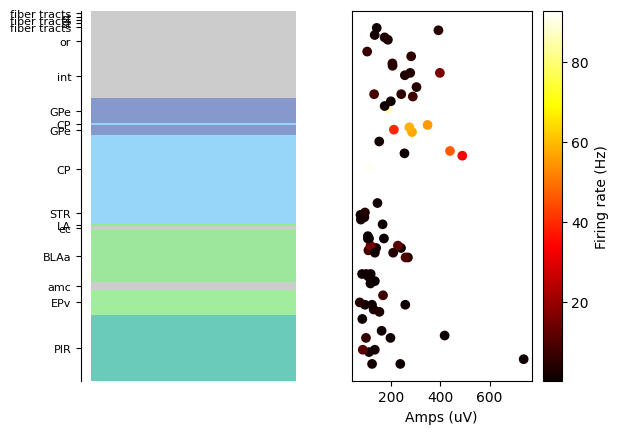

{'amps': array([7.74114636e-05, 8.20599761e-05, 7.58515689e-05, ...,
       1.21547848e-04, 9.61041299e-05, 5.95502585e-05]), 'depths': array([3263.32666016, 2818.59423828,  295.1925354 , ..., 3367.69824219,
       1889.89782715, 2919.24121094]), 'clusters': array([1277, 1120,   73, ..., 1327,  679, 1143], dtype=uint32), 'times': array([7.42929503e-03, 1.88292079e-02, 1.98625333e-02, ...,
       4.10096534e+03, 4.10096630e+03, 4.10097007e+03])}
[False False False ... False False False]
Total no. of clusters: (1751,)
Number of good clusters: (125,)
CP: 53
MOs5: 16
MOs6a: 38
MOs6b: 1
ccb: 3
ccg: 11
cing: 3


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


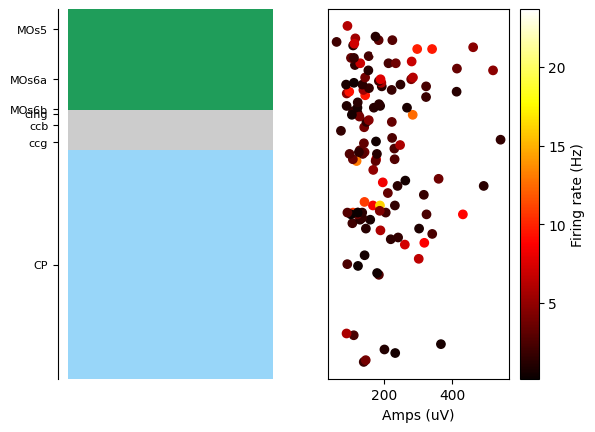

{'amps': array([1.77589922e-04, 1.06016038e-04, 1.47807669e-04, ...,
       7.20841625e-05, 1.61856257e-04, 9.44201380e-05]), 'times': array([1.29934824e-02, 1.47601415e-02, 1.54268054e-02, ...,
       4.10096273e+03, 4.10096370e+03, 4.10096410e+03]), 'clusters': array([ 492,  350,  273, ..., 1526,  863,  841], dtype=uint32), 'depths': array([1183.7800293 ,  867.61877441,  707.67401123, ..., 1932.50622559,
       2035.84802246, 1996.50317383])}
[False False False ... False False False]
Total no. of clusters: (1576,)
Number of good clusters: (73,)
CA3: 9
CL: 9
LD: 1
MD: 39
PCN: 2
SMT: 13


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


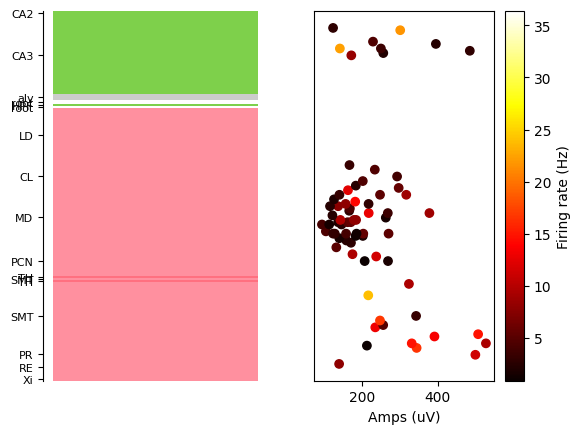

{'clusters': array([ 803, 1330,  753, ...,  406,   51,  653], dtype=uint32), 'times': array([1.11930405e-02, 1.38930296e-02, 1.47930260e-02, ...,
       4.11728067e+03, 4.11728147e+03, 4.11728587e+03]), 'depths': array([1834.45739746, 3521.37524414, 1772.98779297, ...,  977.79473877,
        130.78962708, 1581.00195312]), 'amps': array([1.12137582e-04, 8.40990238e-05, 1.23303759e-04, ...,
       1.32812576e-04, 1.75247086e-04, 1.66285419e-04])}
[False False False ... False False False]
Total no. of clusters: (1579,)
Number of good clusters: (94,)
CA1: 6
CM: 10
DG-mo: 1
IMD: 37
LH: 3
MD: 16
PVT: 1
RH: 5
RSPagl1: 1
RSPagl2/3: 1
RSPagl5: 4
RSPagl6a: 2
VISa2/3: 5
ccb: 1
void: 1


/tmp/ipykernel_1337498/3661281543.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
/tmp/ipykernel_1337498/3661281543.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))


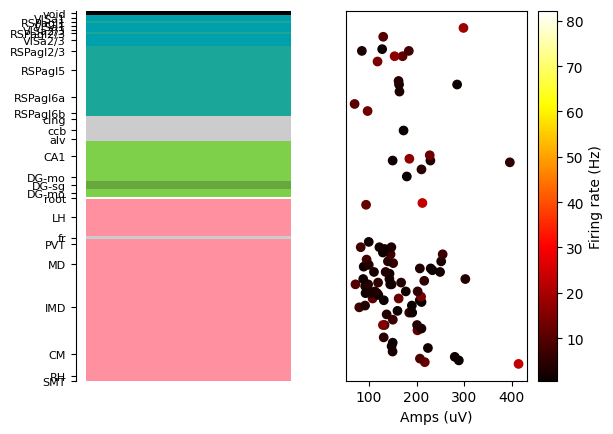

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from scipy.signal import stft, coherence
from scipy.signal import hilbert, welch
from scipy.stats import circmean, circstd


from os.path import join
from pathlib import Path
import spikeglx
from pprint import pprint  # Print larger lists more clearly
import os
os.environ.setdefault('ONE_HTTP_DL_THREADS', '1')

from brainbox.processing import bincount2D
from brainbox.io.one import SessionLoader
from brainbox.io.one import SpikeSortingLoader
from brainbox.ephys_plots import plot_brain_regions
from iblatlas.plots import plot_scalar_on_slice
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas(res_um=10)
from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')
search_terms = one.search_terms('remote')
pprint(search_terms)
search_terms = one.search_terms('remote', 'insertions')
pprint(search_terms)



from psychedelic_functions import paths
from psychedelic_functions import remap, paths
from psychedelic_functions import paths, query_recordings

# from elephant.statistics import instantaneous_rate
# from neo import spike_train

# Get paths
path_dict = paths()

# TO UPDATE
# pip install ibllib --upgrade #IBLLIB
# pip install -U ONE-api #ONE

('extended_qc',
 'dataset_qc_lte',
 'date_range',
 'performance_gte',
 'number',
 'dataset',
 'procedures',
 'end_time',
 'start_time',
 'limit',
 'nickname',
 'location',
 'histology',
 'projects',
 'parent_session',
 'subject',
 'users',
 'project',
 'name',
 'auto_datetime',
 'id',
 'offset',
 'atlas_acronym',
 'datasets',
 'tag',
 'qc',
 'n_trials',
 'dataset_types',
 'type',
 'n_correct_trials',
 'atlas_id',
 'laboratory',
 'json',
 'django',
 'performance_lte',
 'task_protocol',
 'atlas_name',
 'narrative')
('limit',
 'offset',
 'id',
 'name',
 'session',
 'model',
 'serial',
 'auto_datetime',
 'datasets',
 'chronic_insertion',
 'django',
 'subject',
 'date',
 'experiment_number',
 'dataset_types',
 'dataset_qc_lte',
 'lab',
 'project',
 'task_protocol',
 'tag',
 'atlas_name',
 'atlas_acronym',
 'atlas_id')


one.search gives back sessions (EIDs, experimental IDs), one.search_insertions returns insertions instead (PIDs, probe insertion IDs)

In [29]:
'''From IBL_ONE_tutorial.ipynb'''

def display_info (pid, print_info = False):
    eid, pname = one.pid2eid(pid)
    session_path = one.eid2path(eid)
    info = one.get_details(eid)
    datasets = one.list_datasets(eid)
    collections = one.list_collections(eid)
    if print_info == True:
        print(f'\nThe insertion {pid}')
        print(f'comes from {pname} in session: {eid}')
        print(f'session_path: {session_path}')
        pprint (info)
        print('Datasets: ')
        pprint(datasets)
        pprint('Collections: ')
        pprint(collections)
    return eid, pname, session_path

def basic_ephys (pid, pname, session_path):

    # 1. Load in spikesorting data for pid
    ssl = SpikeSortingLoader(one=one, pid=pid, atlas=ba)
    spikes, clusters, channels = ssl.load_spike_sorting()
    print (spikes)
    clusters = ssl.merge_clusters(spikes, clusters, channels)
    # 2. Evaluate the number of good clusters
    # The spikesortingloader loads data for all clusters (both mua and good) detected by the spikesorter.
    # We can restrict to only the good clusters by finding the clusters with a label of 1
    good_cluster_idx = clusters['label'] == 1
    print (good_cluster_idx)
    clusters_good = {key:val[good_cluster_idx] for key, val in clusters.items()}

    all_clusters = clusters['label'].shape
    good_clusters = clusters_good['label'].shape
    print(f'Total no. of clusters: {all_clusters}')
    print(f'Number of good clusters: {good_clusters}')

    # 3. Find the location of clusters in brain
    # The location of the clusters can be found in the atlas_id (Allen CCF ids) or acronym attributes of the clusters object
    acronyms = clusters_good['acronym']
    unique_acronyms, count = np.unique(acronyms, return_counts=True)
    for a, c in zip(unique_acronyms, count):
        print(f'{a}: {c}')

    # 4. Compute the firing rate of each cluster
    # The firing rate of each cluster can be found in the firing rate atrribute of the clusters object
    firing_rate = clusters_good['firing_rate']

    # To show the interaction between the clusters and the spikes object we will show how you can compute
    # the firing rate from the data

    # To compute the firing rate we first need to compute the number of spikes detected for each cluster
    n_spikes = np.empty((clusters_good['cluster_id'].shape))
    # Loop over the cluster ids
    for i, c in enumerate(clusters_good['cluster_id']):
        # Find location where each cluster id is found in the spikes objects and get the sum
        cidx = np.sum(spikes['clusters'] == c)
        n_spikes[i] = cidx

    # To compute the firing rate we can divide the spike count by the total duration of the recording
    duration = np.max(spikes['times']) - np.min(spikes['times'])
    firing_rate_from_spikes = n_spikes / duration
    # Make sure that the values for firing rates are the same
    np.array_equal(firing_rate_from_spikes, firing_rate)

    # 5. Plot firing rate and brain locations
    clusters_good.keys()
    norm = colors.Normalize(vmin=np.min(firing_rate), vmax=np.max(firing_rate), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
    firing_rate_cols = mapper.to_rgba(firing_rate)
    fig, axs = plt.subplots(1, 2)
    # Plot the brain regions through which the channels on the insertion pass
    plot_brain_regions(channels['atlas_id'], channel_depths=channels['axial_um'], ax=axs[0])
    # Plot scatter plot of cluster depths vs cluster amp with firing rate encoded in colour
    # Map firing rate values to colours
    norm = colors.Normalize(vmin=np.min(firing_rate), vmax=np.max(firing_rate), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('hot'))
    firing_rate_cols = mapper.to_rgba(firing_rate)
    axs[1].scatter(clusters_good['amp_median'] * 1e6, clusters_good['depths'], c=firing_rate_cols)
    axs[1].set_xlabel('Amps (uV)')
    axs[1].get_yaxis().set_visible(False)
    cbar = fig.colorbar(mapper, ax=axs[1])
    cbar.set_label('Firing rate (Hz)')
    plt.show()
    plt.close(fig)
    return {a: c for a, c in zip(unique_acronyms, count)}


def load_session (eid):
    print (f'Starting to download session data for {eid}')
    sess_loader = SessionLoader(one=one, eid=eid)
    sess_loader.load_session_data()
    print(sess_loader.data_info)
    # access trials data and list the keys of dataframe
    print(f'Keys in trials data: {sess_loader.trials.keys()}')
    # access wheel data and get the shape of dataframe
    print(f'\nShape of wheel data: {sess_loader.wheel.shape}')
    sess_info = sess_loader.data_info
    return sess_info


In [31]:
dataset = 'spikes.times.npy'
brain_acronym = 'MO'
psychedelic_insertions = one.search_insertions(project=['psychedelics'])
psychedelic_insertions_spikes = one.search_insertions(project=['psychedelics'], datasets=dataset)
psychedelic_insertions_spikes_area = one.search_insertions(project=['psychedelics'], datasets=dataset, atlas_acronym=brain_acronym)

print(f'{len(psychedelic_insertions)-1} insertions in psychedelic project, of which \n{len(psychedelic_insertions_spikes)-1} have a spikes.times.npy file, \n{len(psychedelic_insertions_spikes_area)-1} with areas containing {brain_acronym} in their acronym')
neurons_per_area = {}
datasets_loaded = {}
for pid in psychedelic_insertions_spikes_area:
    eid, pname, session_path = display_info (pid)
    neurons_per_area[pid] = basic_ephys (pid, pname, session_path)
    sess_info = load_session (eid)
    datasets_loaded [eid] = sess_info
    break
df = pd.DataFrame(neurons_per_area).fillna(0)
plt.imshow (df)

52 insertions in psychedelic project, of which 
47 have a spikes.times.npy file, 
16 with areas containing MO in their acronym
{}


TypeError: 'NoneType' object is not subscriptable

In [17]:
# 1. Load in spikesorting data for pid
ssl = SpikeSortingLoader(one=one, pid=pid, atlas=ba)
spikes, clusters, channels = ssl.load_spike_sorting()

In [1]:
import ibllib
import one as one_mod

print(f"ibllib: {ibllib.__version__}")
print(f"one: {one_mod.__version__}")
print(one.alyx._par.ALYX_URL)

ibllib: 2.40.1
one: 2.11.0


NameError: name 'one' is not defined

In [17]:
eid, pname = one.pid2eid(pid)
session_path = one.eid2path(eid)

In [28]:
one.list_collections(
            eid, filename='spikes*', collection=f"alf/{pname}*")

[]

In [26]:
ssl.collections

[]

In [22]:
spike_clusters = np.load ('/home/openlab//Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-06296/2023-07-06/001/alf/probe00/pykilosort/spikes.clusters.npy')

In [29]:
pname

'probe00'

In [ ]:
from ibllib.io import video

label = 'body' # 'left', 'right' or 'body'
url = video.url_from_eid(eid, one=one)[label]

# Load video timestamps
ts = one.load_dataset(eid, f'*{label}Camera.times*', collection='alf')

# Find the frame closest to 1000s into data
frame_n = np.searchsorted(ts, 1000)

# Take the 0-1-2nd frame after this frame_n
frames_id = range(frame_n, frame_n+3)

# Stream the data
frame = video.get_video_frames_preload(url, frames_id)

# Plot the first frame
plt.imshow(frame[0], cmap='gray')

2500


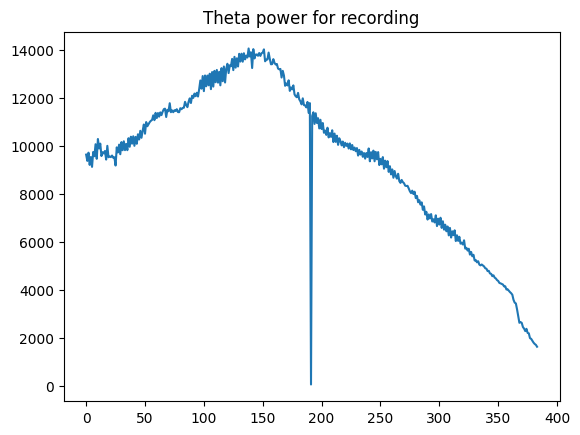

2500
(384,)


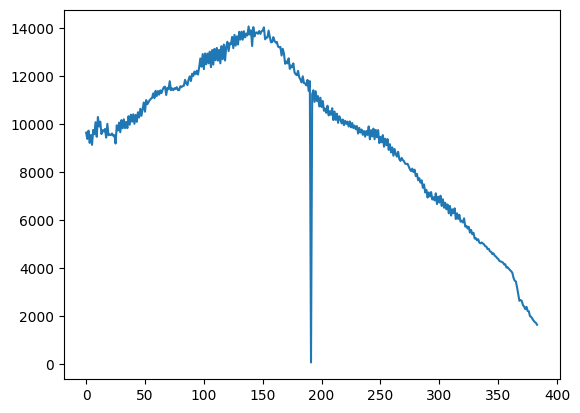

In [2]:
file_path = '/home/openlab/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-05727/2023-02-01/001/raw_ephys_data/probe00/_spikeglx_ephysData_g0_t0.imec0.lf.cbin'
sr = spikeglx.Reader(file_path)

how_many_seconds = 1000

# access the first 10s of data on all non-sync channels
data = sr[0:int(how_many_seconds * sr.fs), :-sr.nsync]

all_frequencies = []
sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
for i in range(data.shape[1]):
    channel_data = data[:,i]
    ft_channel_data = np.fft.rfft(channel_data)
    freqs = np.fft.rfftfreq(len(channel_data), d=1./sampling_rate)
    # all_frequencies.append((freqs, abs(ft_channel_data)))
    # power_spectrum = np.abs(ft_channel_data)**2
    power_spectrum_channel_data = np.abs(ft_channel_data)**2
    all_frequencies.append(power_spectrum_channel_data)

f0 = np.searchsorted(freqs, 4)
fn = np.searchsorted(freqs, 12)
theta_power = np.row_stack(all_frequencies)[:, f0:fn].sum(axis=1)
plt.plot(theta_power)
plt.title('Theta power for recording')
plt.show()

# Compute Fourier Transform for each channel
all_frequencies = []
sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
print (sampling_rate)
for i in range(data.shape[1]):
    channel_data = data[:,i]
    ft_channel_data = np.fft.rfft(channel_data)
    freqs = np.fft.rfftfreq(len(channel_data), d=1./sampling_rate)
    # all_frequencies.append((freqs, abs(ft_channel_data)))
    # power_spectrum = np.abs(ft_channel_data)**2
    power_spectrum_channel_data = np.abs(ft_channel_data)**2
    all_frequencies.append(power_spectrum_channel_data)

f0 = np.searchsorted(freqs, 4)
fn = np.searchsorted(freqs, 12)
theta_power = np.row_stack(all_frequencies)[:, f0:fn].sum(axis=1)
print(theta_power.shape)

# Plot Fourier Transform for each channel
for i, (freqs, ft) in enumerate(all_frequencies):
    plt.figure(i)
    plt.plot(freqs[f0:fn], ft[f0:fn])
    plt.title(f"Channel {i} Fourier Transform")
    plt.ylabel("Power")
    plt.xlabel("Frequency")
    plt.xlim(0, sampling_rate / 2)
plt.show()


plt.plot(theta_power)

sampling_rate = int(sr.fs) # assuming sr.fs is your sampling rate
print(sampling_rate)
data.shape
t_min = 10000
t_max = 20000
ch = 101

fig, axs = plt.subplots(3)
axs[0].matshow(data[t_min:t_max].T, aspect = 'auto')
axs[1].plot(data[t_min:t_max, ch])
spike_times = spikes['times'][spikes['clusters']==475]
print 
spike_times = spike_times[spike_times<(t_max/sampling_rate)]
axs[2].scatter(spike_times*sampling_rate, np.ones_like(spike_times))